# Bias-variance trade-off

Measure bias and variance for a tiny subsample of a test set. We avg the error from each prediction and if test set is too big not seeing very high variance due to avg smoothing.

In [92]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from sklearn import tree
from dtreeviz.trees import *

### Regression

In [149]:
# can't use too many records as model.score() will be average of many values
# which reduces variance; we're trying to highlight not hide that variance
df_rent = pd.read_csv("data/rent-ideal.csv", nrows=4000)
X = df_rent[['bedrooms','bathrooms','latitude','longitude']]
y = df_rent['price']
X.head()

,bedrooms,bathrooms,latitude,longitude
0,3,1.5,40.7145,-73.9425
1,2,1.0,40.7947,-73.9667
2,1,1.0,40.7388,-74.0018
3,1,1.0,40.7539,-73.9677
4,4,1.0,40.8241,-73.9493


In [159]:
def rent():
    # can't use too many records as model.score() will be average of many values
    # which reduces variance; we're trying to highlight not hide that variance
    df_rent = pd.read_csv("data/rent-ideal.csv")
    X = df_rent[['bedrooms','bathrooms','latitude','longitude']].values
    y = df_rent['price'].values

    # shuffle
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]
    return X, y

def testobs(X, y, nchunks = 200, ntests=5):
    n = len(X)
    chunk_size = n // nchunks

    # grab say just 5 records; too many and average r2 over test set shows too little variance
    if chunk_size<ntests:
        raise "Oops"
    X_test, y_test = X[0:ntests], y[0:ntests]
    return X_test, y_test, chunk_size

In [175]:
nchunks = 200
X, y = rent()
X_test, y_test, chunk_size = testobs(X, y, nchunks=nchunks, ntests=5)

In [180]:
max_features = 1.0      # use this to simulate bagging but not RF
max_features = 'auto'
n_estimators = 20

leaf_sizes = [1,2,3,4,5,10,15,20,30]

all_test_scores = np.zeros(shape=(len(leaf_sizes), nchunks-1)) # first chunk is test set
for i,min_samples_leaf in enumerate(leaf_sizes):
    print(f"min_samples_leaf={min_samples_leaf}: ", end='')
    test_scores = []
    for j in range(1,nchunks): # first chunk is test set; skip
#         print(j,' ', end='')
        X_train = X[j*chunk_size:j*chunk_size+chunk_size]
        y_train = y[j*chunk_size:j*chunk_size+chunk_size]
        rf = RandomForestRegressor(n_estimators=n_estimators,
                                   min_samples_leaf=min_samples_leaf,
                                   max_features=max_features,
                                   bootstrap=True)
        rf.fit(X_train, y_train)
        s = rf.score(X_test, y_test)
        test_scores.append(s)

    all_test_scores[i] = test_scores
    avg = np.mean(test_scores)
    std = np.std(test_scores)
    print(avg, std)

min_samples_leaf=1: 0.6713010546479413 0.14855417433670154
min_samples_leaf=2: 0.6762679709404139 0.12958940985455938
min_samples_leaf=3: 0.6833242177554568 0.10803162815588489
min_samples_leaf=4: 0.6806683858830364 0.10982009438592745
min_samples_leaf=5: 0.6830135761648377 0.10065651085093534
min_samples_leaf=10: 0.6793224783889863 0.09115567977985234
min_samples_leaf=15: 0.6333532762431585 0.08192866693834248
min_samples_leaf=20: 0.5997821864958114 0.0867688659903629
min_samples_leaf=30: 0.40000448261483607 0.11468189309231175


In [182]:
test_means = np.mean(all_test_scores, axis=1)
test_variances = np.std(all_test_scores, axis=1)
test_variances

array([0.14855417, 0.12958941, 0.10803163, 0.10982009, 0.10065651,
       0.09115568, 0.08192867, 0.08676887, 0.11468189])

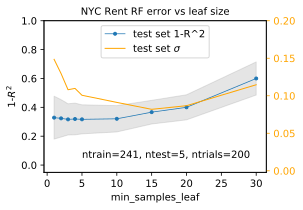

In [183]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)

a = ax.plot(leaf_sizes, 1-test_means, lw=.75, marker='.', label="test set 1-R^2")

plt.fill_between(leaf_sizes, 
                 1-test_means - test_variances,
                 1-test_means + test_variances,
                 color='gray', alpha=0.2)

ax2 = ax.twinx()
b = ax2.plot(leaf_sizes, test_variances, lw=1, label="test set $\sigma$", c='orange')
ax2.yaxis.label.set_color('orange')
#ax2.set_ylabel("Test $\sigma$")
ax2.tick_params(axis='y', colors='orange')
ax2.set_ylim(-0.002,0.2)

ax.set_xlabel("min_samples_leaf")
ax.set_ylabel("1-$R^2$")
ax.set_ylim(-.05,1.0)
lines = a+b
labels = [l.get_label() for l in lines]
ax.legend(lines,labels,loc='upper center')

ax.text(5,.05,f"ntrain={len(X_train)}, ntest={len(X_test)}, ntrials={nchunks}")

if max_features==1.0:
    ax.set_title("NYC Rent bagged forest error vs leaf size", fontsize=10)
else:
    ax.set_title("NYC Rent RF error vs leaf size", fontsize=10)

### Classification

In [123]:
digits = load_digits()

df_digits = pd.DataFrame(data=digits.data)
df_digits['digit'] = digits.target
df_digits = df_digits.sample(n=500)
X = df_digits.drop('digit', axis=1)
y = df_digits['digit']

In [136]:
ntrials = 20
n_hyperparameters = 50
n = len(X)
ntrain = int(n * 0.8)
leaf_sizes = list(range(1, int(n*.6), n // n_hyperparameters))
all_train_scores = np.zeros(shape=(ntrials, len(leaf_sizes)))
all_test_scores = np.zeros(shape=(ntrials, len(leaf_sizes)))

for i in range(ntrials):
    print(f"Trial {i}")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

    train_scores = []
    test_scores = []
    for m in leaf_sizes:
        t = DecisionTreeClassifier(min_samples_leaf=m)
        t.fit(X_train, y_train)
        s = t.score(X_test, y_test)
        train_s = t.score(X_train, y_train)
        test_scores.append(s)
        train_scores.append(train_s)
#         print(f"samples / leaf = {m:5d}, score is {s:.2f}")
    test_scores = np.array(test_scores)
    train_scores = np.array(train_scores)
    all_test_scores[i] = test_scores
    all_train_scores[i] = train_scores

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19


In [137]:
test_means = np.mean(all_test_scores, axis=0)
test_variances = np.std(all_test_scores, axis=0)
train_variances = np.std(all_train_scores, axis=0)
test_variances

array([0.05517246, 0.07522633, 0.06581033, 0.04894895, 0.07605261,
       0.06048967, 0.05215362, 0.0608605 , 0.06192738, 0.06837397,
       0.08130806, 0.071631  , 0.06276942, 0.06321392, 0.04308132,
       0.048     , 0.04820788, 0.03841875, 0.03993745, 0.03315117,
       0.04642198, 0.04608687, 0.04608687, 0.04409082, 0.03128898,
       0.03128898, 0.03128898, 0.03128898, 0.03128898, 0.03128898])

Text(0.5, 1.0, 'MNIST digits error, stddev versus leaf size')

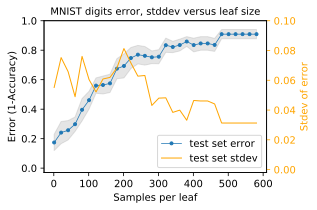

In [141]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)
a = ax.plot(leaf_sizes, 1-test_means, lw=.75, marker='.', label="test set error")

plt.fill_between(leaf_sizes,
                 1-test_means - test_variances,
                 1-test_means + test_variances,
                 color='gray', alpha=0.2)

ax2 = ax.twinx()
b = ax2.plot(leaf_sizes, test_variances, lw=1, label="test set stdev", c='orange')
ax2.yaxis.label.set_color('orange')
ax2.tick_params(axis='y', colors='orange')
ax2.set_ylabel("Stdev of error")
ax2.set_ylim(-0.002,0.1)

ax.set_xlabel("Samples per leaf")
ax.set_ylabel("Error (1-Accuracy)")
ax.set_ylim(-.03,1.0)

lines = a+b
labels = [l.get_label() for l in lines]
ax.legend(lines,labels,loc='lower right')

ax.set_title("MNIST digits error, stddev versus leaf size", fontsize=10)

## Error sources diagrams

Text(0.5, 1.0, 'Perfect $y = f(X) = (X-2)^2$ data')

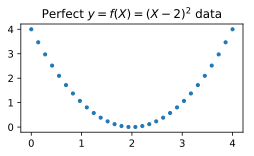

In [101]:
X = np.linspace(0,4,30)
y = (X-2)**2
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10)
ax.set_title("Perfect $y = f(X) = (X-2)^2$ data")

Text(0.5, 1.0, 'Inconsistent $y = f(X) = (X-2)^2$ data')

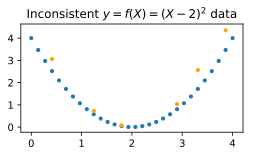

In [102]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10)
for i in [3,9,13,21,24,28]:
    ax.scatter([X[i]],[y[i]+np.random.rand()],s=10,c='orange')
ax.set_title("Inconsistent $y = f(X) = (X-2)^2$ data")

In [103]:
X = np.linspace(0,4,30)
y = (X-2)**2 + np.random.random(size=len(X))*1.5
y_ = (X-2)**2 + np.random.random(size=len(X))*1.5

Text(0.5, 1.0, 'Noisy $y = f(X) = (X-2)^2 + \\epsilon$ data')

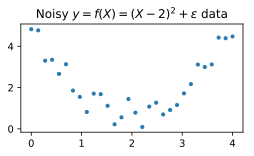

In [104]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.set_title("Noisy $y = f(X) = (X-2)^2 + \epsilon$ data")

Text(0.5, 1.0, 'Underfit (shallow) decision tree')

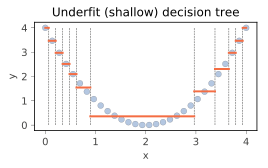

In [105]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
t = rtreeviz_univar(ax,
                    X, (X-2)**2,
                    max_depth=4,
                    feature_name='x',
                    target_name='y',
                    fontsize=10,
                    colors={'scatter_edge': 'black'},
                   show=['splits'])
ax.set_title("Underfit (shallow) decision tree")

Text(0.5, 1.0, 'Noisy data (shallow) decision tree')

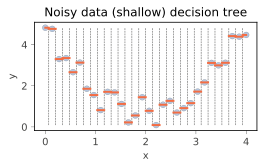

In [106]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
t = rtreeviz_univar(ax,
                    X, y,
                    max_depth=10,
                    feature_name='x',
                    target_name='y',
                    fontsize=10,
                    colors={'scatter_edge': 'black'},
                   show=['splits'])
ax.set_title("Noisy data (shallow) decision tree")

Text(0.5, 1.0, 'Underfit')

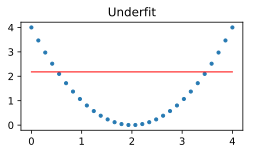

In [107]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,(X-2)**2,s=10,c='#2679B2')
ax.plot([0,4], [np.mean(y)]*2, c='red',lw=1)
ax.set_title("Underfit")

Text(0.5, 1.0, 'Underfit')

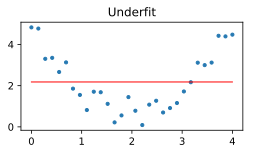

In [108]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.plot([0,4], [np.mean(y)]*2, c='red',lw=1)
ax.set_title("Underfit")

Text(0.5, 1.0, 'Balanced model')

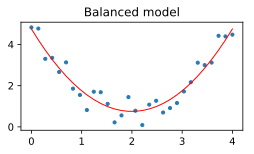

In [109]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.plot(X,(X-2)**2+.75, c='red',lw=1)
ax.set_title("Balanced model")

Text(0.5, 1.0, 'Overfit model')

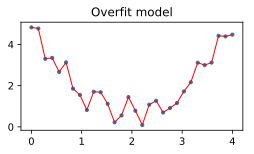

In [110]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
ax.plot(X,y,c='red',lw=1)
ax.set_title("Overfit model")

In [111]:
# do overfitting on non-noisy data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

X = np.linspace(0,4,30)
y = (X-2)**2 + np.random.random(size=len(X))

model = Pipeline([('poly', PolynomialFeatures(degree=27)),
                  ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-3 polynomial data
#y = 3 - 2 * X + X ** 2 - X ** 3
model = model.fit(X[:, np.newaxis], y)
coef = model.named_steps['linear'].coef_
coef

array([ 4.91552133e-01,  5.15573238e-01,  3.87150039e-01,  3.14139932e-01,
        2.55275972e-01,  1.94227040e-01,  1.23599370e-01,  4.24870503e-02,
       -4.25575167e-02, -1.16332267e-01, -1.56497657e-01, -1.41043297e-01,
       -6.33606199e-02,  4.96345486e-02,  1.32164098e-01,  1.11145288e-01,
       -1.83692442e-02, -1.32405999e-01, -6.53182020e-02,  1.18918612e-01,
        6.81211211e-02, -1.65539827e-01,  1.13866302e-01, -4.29246191e-02,
        9.89800126e-03, -1.39996084e-03,  1.12208251e-04, -3.92024295e-06])

Text(0.5, 1.0, 'Overfit degree 27 polynomial on noisy data')

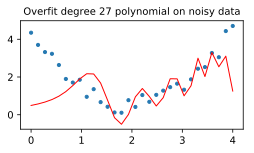

In [112]:
fig, ax = plt.subplots(1,1, figsize=(4,2))
ax.scatter(X,y,s=10,c='#2679B2')
#ax.plot(X,coef[0]+coef[1]*X + coef[2]*X**2 + coef[3]*X**3)
ax.plot(X,model.predict(X.reshape(-1,1)), c='red', lw=1)
ax.set_title("Overfit degree 27 polynomial on noisy data", fontsize=10)

Text(0.5, 1.0, 'Ensemble of overfit models')

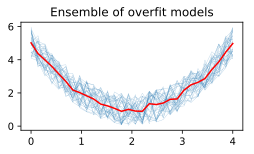

In [113]:
X = np.linspace(0,4,30)
ntrials = 35
fig, ax = plt.subplots(1,1, figsize=(4,2))
ys = np.zeros(shape=(ntrials,len(X)))
for i in range(ntrials):
    y = (X-2)**2 + np.random.random(size=len(X))*2.0
    ys[i] = y
#    ax.scatter(X,y,s=.25,c='#2679B2')
    ax.plot(X,y,c='#2679B2',lw=.25, alpha=.5)

y_avg = np.mean(ys,axis=0)
#ax.scatter(X,y,s=.5,c='#2679B2')
ax.plot(X,y_avg,c='red',lw=1.5)

#ax.set_title("Overfit model")
ax.set_title("Ensemble of overfit models")